# Basic Usage

This tutorial will demonstrate the most basic Gryffin functionality. We will optimize a single parameter with respect to a simple one dimensional objective function. 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import pandas as pd
from gryffin import Gryffin

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set(context='talk', style='ticks')

Let's define the objective function and a helper function that will parse the Gryffin param dict for us:  

In [2]:
def objective(x):
    
    def sigmoid(x, l, k, x0):
        return l / (1 + np.exp(-k*(x-x0)))

    sigs = [sigmoid(x, -1, 40, 0.2),
            sigmoid(x,  1, 40, 0.4),
            sigmoid(x,  -0.7, 50, 0.6),
            sigmoid(x, 0.7, 50, 0.9)
           ]

    return np.sum(sigs, axis=0) + 1

def compute_objective(param):
    x = param['x']
    param['obj'] = objective(x)
    return param

Unlike in most use-cases, we can now visualize the objective function:

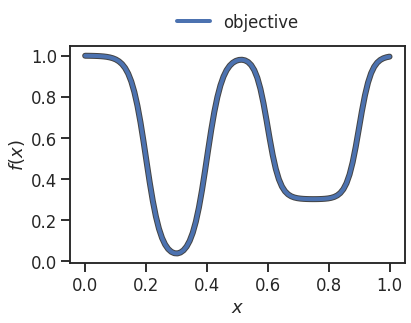

In [11]:
x = np.linspace(0, 1, 100)
_ = plt.plot(x, objective(x), linewidth=6, color='#444444')
_ = plt.plot(x, objective(x), linewidth=4, label='objective')
_ = plt.xlabel('$x$')
_ = plt.ylabel('$f(x)$')
_ = plt.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5 ,1.), frameon=False)

We define ``Gryffin``'s configuration as a dictionary. Note that the config can also be passed into ``Gryffin`` as a ``json`` file using the ``config_file`` argument. A continuous parameter ``x`` is defined and bounded by ``0.0 < x < 1.0``. We also define a minimization objective.

In [8]:
config = {
    "parameters": [
        {"name": "x", "type": "continuous", "low": 0., "high": 1., "size": 1}
    ],
    "objectives": [
        {"name": "obj", "goal": "min"}
    ]
}

``Gryffin``'s instance can now be initialized with the configuration above. Here we select ``silent=True`` to suppress the rich display in the notebook. Only warnings and errors will be printed.

In [9]:
gryffin = Gryffin(config_dict=config, silent=True)

In the cell below, we perform a sequential optimization for a maximum of 15 evaluations. 

In [6]:
observations = []
MAX_ITER = 15

for num_iter in range(MAX_ITER):
    print('-'*20, 'Iteration:', num_iter+1, '-'*20)
    
    # Query for new parameters
    params = gryffin.recommend(observations=observations)s
    
    # Params is a list of dict, where each dict containts the proposed parameter values, e.g., {'x':0.5}
    # in this example, len(params) == 1 and we select the single set of parameters proposed
    param = params[0]
    print('  Proposed Parameters:', param, end=' ')
        
    # Evaluate the proposed parameters. "compute_objective" takes param, which is a dict, and adds the key "obj" with the
    # objective function value
    observation = compute_objective(param)
    print('==> :', observation['obj'])
    
    # Append this observation to the previous experiments
    observations.append(observation)

-------------------- Iteration: 1 --------------------


Could not find any observations, falling back to random sampling

  Proposed Parameters: {'x': 0.7487201} ==> Merit: 0.30077459774347426
-------------------- Iteration: 2 --------------------
  Proposed Parameters: {'x': 0.0077615599147975445} ==> Merit: 0.9995427730859534
-------------------- Iteration: 3 --------------------
  Proposed Parameters: {'x': 0.654929725840613} ==> Merit: 0.34216585550843215
-------------------- Iteration: 4 --------------------
  Proposed Parameters: {'x': 0.8494183421134949} ==> Merit: 0.3516937109818943
-------------------- Iteration: 5 --------------------
  Proposed Parameters: {'x': 0.7985361218452454} ==> Merit: 0.3043904616235271
-------------------- Iteration: 6 --------------------
  Proposed Parameters: {'x': 0.3264615833759308} ==> Merit: 0.0564524190695449
-------------------- Iteration: 7 --------------------
  Proposed Parameters: {'x': 0.3942805068402703} ==> Merit: 0.4434508813154385
-------------------- Iteration: 8 --------------------
  Proposed Parameters: {'x': 0.23461488902258504} ==> Merit: 0.2016

Let's now plot all the parameters that have been probed and the best solution found.

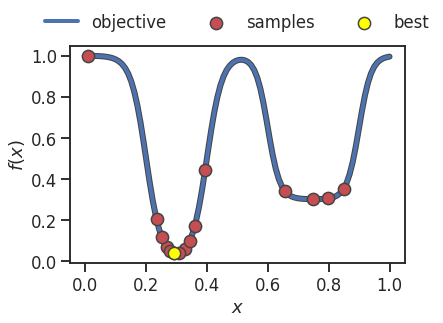

In [7]:
# objective function
x = np.linspace(0, 1, 100)
y = [objective(x_i) for x_i in x]

# observed parameters and objectives
samples_x = [obs['x'] for obs in observations]
samples_y = [obs['obj'] for obs in observations]

_ = plt.plot(x, y, linewidth=6, color='#444444')
_ = plt.plot(x, y, linewidth=4, label='objective')

_ = plt.scatter(samples_x, samples_y, zorder=10, s=150, color='r', edgecolor='#444444', label='samples')

# highlight best
_ = plt.scatter(samples_x[np.argmin(samples_y)], np.min(samples_y), zorder=11, s=150, 
                color='yellow', edgecolor='#444444', label='best')

# labels
_ = plt.xlabel('$x$')
_ = plt.ylabel('$f(x)$')
_ = plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5 ,1.), frameon=False)